<h> A common technique in transfer learning: fine tuning <br>
    Steps: <br>
    * Pre-train a neural network model <br>
    * Create a new neural network model, i.e., the target model. This replicates all model designs and their parameters on the         source model, except the output layer.(. We assume that these model parameters contain the knowledge learned from the           source dataset and this knowledge will be equally applicable to the target dataset.We also assume that the output layer of       the source model is closely related to the labels of the source dataset and is therefore not used in the target model.) <br>
    * Add an output layer whose output size is the number of target dataset categories to the target model, and randomly               initialize the model parameters of this layer.<br>
    * Train the target model on a target dataset. We will train the output layer from scratch, while         
      the parameters of all remaining layers are fine-tuned based on the parameters of the source model.<br>
     

## Hot Dog recognition:
### Check Whether there is a hot dog or not

In [1]:
%matplotlib inline
import os
import re
import requests
import zipfile
import hashlib
import collections
import random

import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from custom import Accumulator as Accumulator

### Data

In [2]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [3]:
train_imgs = torchvision.datasets.ImageFolder('train')
test_imgs = torchvision.datasets.ImageFolder('test')

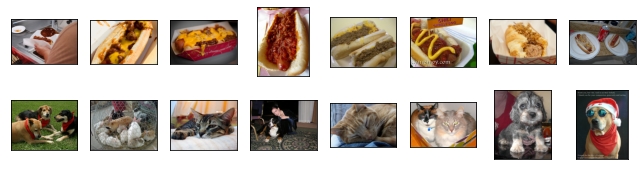

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [5]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomVerticalFlip(p=0.5),
#     torchvision.transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
#     torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

 <h> We use ResNet-18, which was pre-trained on the ImageNet dataset, as the source model

In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

<h> The pre-trained source model instance contains two member variables: features and output. The former contains all layers of the model, except the output layer, and the latter is the output layer of the model. The main purpose of this division is to facilitate the fine tuning of the model parameters 
    of all layers except the output layer

In [7]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

<h> We then build a new neural network to use as the target model. It is defined in the same way as the pre-trained source model, but the final number of outputs is equal to the number of categories in the target dataset

In [8]:
finetune_net = torchvision.models.resnet50(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
# finetune_net.fc = nn.Sequential(nn.Linear(finetune_net.fc.in_features,500),
# nn.ReLU(),
# nn.Dropout(), nn.Linear(500,2))
nn.init.xavier_uniform_(finetune_net.fc.weight);

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(finetune_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### temps

In [9]:
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)        
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

## Main

In [10]:
def train_batch(net,X,y,loss,trainer,device):
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train(net, train_iter, loss, trainer, num_epochs,device):
    num_batches = len(train_iter)
    net = net.to(device)
    for epoch in range(num_epochs):
        print("[EPOCH]", epoch)
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            l, acc = train_batch(
                net, features, labels, loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
#         test_acc = evaluate_accuracy_gpu(net, test_iter)
        print("Accuracy: ",(metric[1] / metric[3])*100)
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}')



# If `param_group=True`, the model parameters in fc layer will be updated
# using a learning rate ten times greater, defined in the trainer.
def train_fine_tuning(net,learning_rate,batch_size = 30,num_epochs = 10, param_group = True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('train',transform=train_augs),
                                                 batch_size=batch_size,shuffle = True)
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    train(net, train_iter, loss, trainer, num_epochs,
                   device)

In [11]:
train_fine_tuning(finetune_net, 5e-5)

[EPOCH] 0
Accuracy:  87.57332174668694
[EPOCH] 1
Accuracy:  92.24418857267
[EPOCH] 2
Accuracy:  93.2869867477732
[EPOCH] 3
Accuracy:  94.00391049315664
[EPOCH] 4
Accuracy:  94.30805996089506
[EPOCH] 5
Accuracy:  94.95980882033457
[EPOCH] 6
Accuracy:  93.65631110145557
[EPOCH] 7
Accuracy:  94.7425592005214
[EPOCH] 8
Accuracy:  95.0032587442972
[EPOCH] 9
Accuracy:  95.78535737562459
loss 0.107, train acc 0.958


In [12]:
torch.cuda.empty_cache()

In [15]:
import pandas as pd


sample = pd.read_csv("Prediction_1.csv")

test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('test',transform=test_augs),batch_size=5)

ones = 0
zeros = 0

j = 0
for i, (features, labels) in enumerate(test_iter):
    features = features.to(device)
    y = finetune_net(features)
    A = torch.argmax(y,axis = 1)
    for k in range(A.shape[0]):
        if A[k] == 1:
            ones += 1
        else:
            zeros += 1
    for k in range(0,5):
        sample['label'][j] = (A[k].item()==0)
        j += 1
    torch.cuda.empty_cache()
            
print(ones,zeros)
# sample

C:\Users\Jayanth\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


851 299


In [16]:
sample.to_csv('Prediction_5.csv',index=False)